# Overview
This notebook introduces you MONAI's image transformation module.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# assumes the framework is found here, change as necessary
sys.path.append("../..")
import monai
import monai.transforms.compose as transforms
from monai.transforms.composables import \
    LoadNifti, LoadNiftid, AddChanneld, ScaleIntensityRanged, \
    Rand3DElasticd, RandAffined, \
    Spacingd, Orientationd

monai.config.print_config()

MONAI version: 0.0.1
Python version: 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.18.2
Pytorch version: 1.4.0
Ignite version: 0.3.0


## Data sources
Starting from a list of filenames. 

The following is a simple python script
to group pairs of image and label from `Task09_Spleen/imagesTr` and `Task09_Spleen/labelsTr`
folder. 

In [2]:
data_root = 'temp/Task09_Spleen'

import os
import glob
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

The image file names are organised into a list of dictionaries.

In [3]:
train_data_dicts[0]

{'image': 'temp/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': 'temp/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

The list of data dictionaries, `train_data_dicts`, could be used by
PyTorch's data loader.

For example,

```python
from torch.utils.data import DataLoader

data_loader = DataLoader(train_data_dicts)
for training_sample in data_loader:
    # run the deep learning training with training_sample
```

The rest of this tutorial presents a set of "transforms"
converting `train_data_dict` into data arrays that
will eventually be consumed by the deep learning models.

## Load the NIfTI files

One design choice of MONAI is that it provides not only the high-level workflow components,
but also relatively lower level APIs in their minimal functioning form.

For example, a `LoadNifti` class is a simple callable wrapper of the underlying `Nibabel` image loader.
After constructing the loader with a few necessary system parameters,
calling the loader instance with a NIfTI filename will return the image data arrays, as well as the metadata -- such as affine information and voxel sizes.

In [4]:
loader = LoadNifti(dtype=np.float32)

In [5]:
image, metadata = loader(train_data_dicts[0]['image'])
print('input:', train_data_dicts[0]['image'])
print('image shape', image.shape)
print('image affine', metadata['affine'])
print('image pixdim', metadata['pixdim'])

input: temp/Task09_Spleen/imagesTr/spleen_10.nii.gz
image shape (512, 512, 55)
image affine [[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
image pixdim [1.       0.976562 0.976562 5.       0.       0.       0.       0.      ]


Oftentimes, we want to load a group of inputs as a training sample.
For example training a supervised image segmentation network requires a pair of image and label as a training sample.

To ensure a group of inputs are beining preprocessed consistently,
MONAI also provides dictionary-based interfaces for the minimal functioning transforms.

`LoadNiftid` is the corresponding dict-based version of `LoadNifti`:

In [6]:
loader = LoadNiftid(keys=('image', 'label'))

In [7]:
data_dict = loader(train_data_dicts[0])
print('input:', train_data_dicts[0])
print('image shape', data_dict['image'].shape)
print('label shape', data_dict['label'].shape)
print('image affine', data_dict['image.affine'])
print('image pixdim', data_dict['image.pixdim'])

input: {'image': 'temp/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': 'temp/Task09_Spleen/labelsTr/spleen_10.nii.gz'}
image shape (512, 512, 55)
label shape (512, 512, 55)
image affine [[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]
image pixdim [1.       0.976562 0.976562 5.       0.       0.       0.       0.      ]


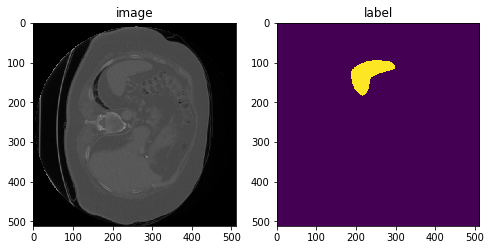

In [8]:
image, label = data_dict['image'], data_dict['label']
plt.figure('visualise', (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

## Add the channel dimension

Most of MONAI's image transformations assume that the input data has the shape:

`[num_channels, spatial_dim_1, spatial_dim_2, ... ,spatial_dim_n]`

so that they could be interpreted consistently (as "channel-first" is commonly used in PyTorch).

Here the input image has shape `(512, 512, 55)` which isn't in the acceptable shape,

we therefore create a transform which is called to updat the shape:

In [9]:
add_channel = AddChanneld(keys=['image', 'label'])
data_dict = add_channel(data_dict)
print('image shape', data_dict['image'].shape)

image shape (1, 512, 512, 55)


Now we are ready to do some intensity and spatial transforms.

## Resample to a consistent voxel size

The input volumes might have different voxel sizes,

The following transform is created to normlise the volumes to have (1.5, 1.5, 5.) millimeter voxel size.

The transform is set to read the original voxel size from `data_dict['image.affine']`,
which is from the corresponding NIfTI file, read by `LoadNiftid`.

In [10]:
spacing = Spacingd(keys=['image', 'label'], 
                   pixdim=(1.5, 1.5, 5.), interp_order=(2, 0))
data_dict = spacing(data_dict)

In [11]:
data_dict = spacing(data_dict)
print(data_dict['image'].shape)
print(data_dict['label'].shape)
print(np.diag(data_dict['image.original_affine']), 
      np.diag(data_dict['label.original_affine']))
print(np.diag(data_dict['image.affine']), 
      np.diag(data_dict['label.affine']))

(1, 334, 334, 55)
(1, 334, 334, 55)
[0.97656202 0.97656202 5.         1.        ] [0.97656202 0.97656202 5.         1.        ]
[1.5 1.5 5.  1. ] [1.5 1.5 5.  1. ]


A `spacing` key is added to the `data_dict`, logs the original pixdim, and the current pixdim.

## Random affine transformation

In [12]:
rand_affine = RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0,
                          spatial_size=(400, 400, 50),
                          translate_range=(50, 50, 2),
                          rotate_range=(np.pi/36, np.pi/36, np.pi*2),
                          scale_range=(0.15, 0.15, 0.15),
                          padding_mode='border')

image shape torch.Size([1, 400, 400, 50])


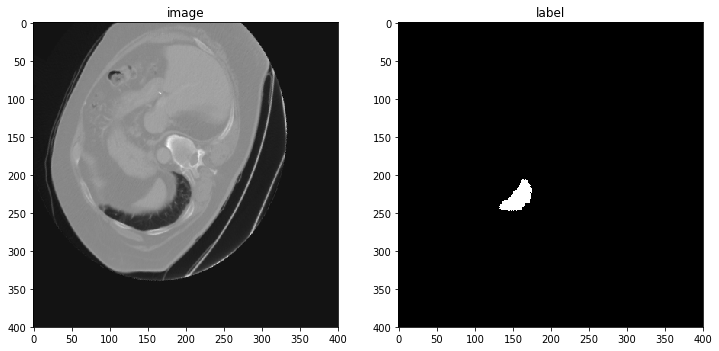

In [13]:
affined_data_dict = rand_affine(data_dict)
print('image shape', affined_data_dict['image'].shape)

image, label = affined_data_dict['image'][0], affined_data_dict['label'][0]
plt.figure('visualise', (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30], cmap='gray')
plt.show()

## Random elastic deformation

In [14]:
rand_elastic = Rand3DElasticd(
    keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0,
    sigma_range=(10, 10),
    magnitude_range=(200, 400),
    spatial_size=(400, 400, 50),
    translate_range=(50, 50, 2),
    rotate_range=(np.pi/36, np.pi/36, np.pi*2),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode='border')

image shape (1, 400, 400, 50)


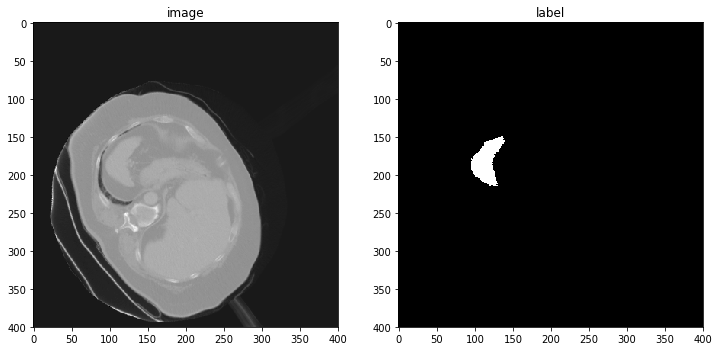

In [16]:
deformed_data_dict = rand_elastic(data_dict)
print('image shape', deformed_data_dict['image'].shape)

image, label = deformed_data_dict['image'][0], deformed_data_dict['label'][0]
plt.figure('visualise', (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30], cmap='gray')
plt.show()